# Computational Cognitive Neuroscience Practical Assignment 5
## Q Learning
### Tommy Clausner (s4836219) and Steven Smits (s4237263)

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import chainer
from chainer import optimizers
import chainer.functions as F
import chainer.links as L

## Environment provided by assigment is defined

In [21]:
class EvidenceEnv(object):
    """
    Very simple task which only requires evaluating present evidence and does not require evidence integration.
    The actor gets a reward when it correctly decides on the ground truth. Ground truth 0/1 determines probabilistically
    the number of 0s or 1s as observations
    """

    def __init__(self, n=1, p=0.8):
        """

        Args:
            n: number of inputs (pieces of evidence)
            p: probability of emitting the right sensation at the input
        """

        self.n_input = n
        self.p = p
        self.n_action = 2

        self._state = None

    def reset(self):
        """
        Resets state and generates new observations

        Returns:
            observation
        """

        # generate state
        self._state = np.random.choice(2)

        return self.observe()

    def step(self, action):
        """
        Executes action, updates state and returns an observation, reward, done (episodic tasks) and optional information

        :param action:
        :return: observation, reward, done, info
        """

        # return 1 for correct decision and -1 for incorrect decision
        reward = (2 * (action == self._state) - 1)

        # generate state
        self._state = np.random.choice(2)

        # we are always done after each decision
        done = True

        return self.observe(), reward, done, None

    def observe(self):
        """
        Helper function which generates an observation based on a state

        :return: observation
        """

        # generate associated observations
        P = [self.p, 1 - self.p] if self._state == 0 else [1 - self.p, self.p]

        return np.random.choice(2, self.n_input, True, P).astype('float32').reshape([1, self.n_input])[0]

    def render(self):
        """
        Takes care of rendering

        :return:
        """

        pass#print self._state

    def close(self):
        """
        Closes the rendering

        :return:
        """
        pass

    def asint(self,obs):
        """
        Represent input observations as an integer number
        :param obs:
        :return:
        """
        return int(sum(2**i*b for i, b in enumerate(obs)))

    def asbinary(self, i, b_len):
        """
        Represent integer as binary array
        :param i: integer
        :param b_len: length of binary array
        :return:
        """

        # get binary representation from integer
        _b = [int(x) for x in list('{0:0b}'.format(i))]
        _b = [0 for i in range(b_len - len(_b))] + _b

        return _b


### Defining own functions

In [22]:
def apply():
    # Number of iterations
    n_iter = 1000
    # environment specs
    env = EvidenceEnv(n=2, p=0.95)
    # define agent
    agent = RandomAgent(env)
    # reset environment and agent
    obs = env.reset()
    reward = None
    done = False
    R = []

    for step in range(n_iter):
        env.render()
        action = agent.act(obs)
        _obs, reward, done, _ = env.step(action)
        # no training involved for random agent
        agent.train(action, obs, reward, _obs)
        obs = _obs
        R.append(reward)
    return R, agent

def plot_cum(R, title, color='red'):
    cumR = np.zeros(len(R))
    for i in range(len(R)):
        cumR[i] = np.sum(R[0: i + 1])

    plt.figure()
    plt.plot(cumR, color=color);
    plt.xlabel('Epoch');
    plt.ylabel('Cumulative reward');
    plt.title(title);
    Rsum = np.sum(R)
    text = 'Final reward: ' + str(Rsum)
    Rmax = np.max(cumR)

    plt.text(400, Rmax, text, style='italic',
             bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 3});

### Part 1 Random agent (demo)

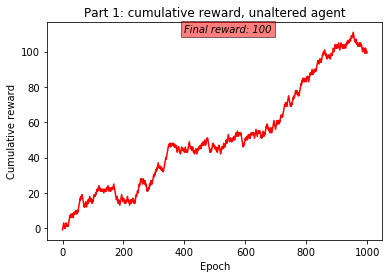

In [33]:
class RandomAgent(object):

    def __init__(self, env):
        """
        Args:
        env: an environment
        """
        self.env = env


    def act(self, onbservation):
        """
        Act based on observation and train agent on cumulated reward (return)
        :param observation: new observation
        :param reward: reward gained from previous action; None indicates no reward because of initial state
        :return: action (Variable)
        """
        return np.random.choice(self.env.n_action)


    def train(self, a, old_obs, new, new_obs):
        """
        :param a: action
        :param old_obs: old observation
        :param r: reward
        :param new_obs: new observation
        :return:
        """
        pass
R,agent = apply()
plot_cum(R, 'Part 1: cumulative reward, unaltered agent')
plt.show()

### Part 2 Tabular Q agent

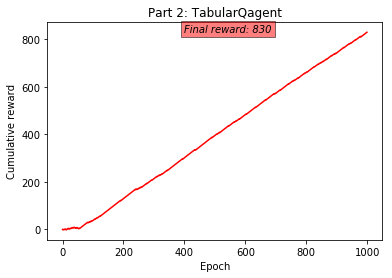

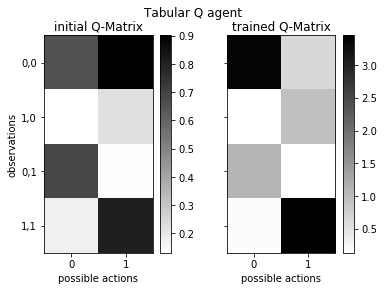

In [23]:
def doQlearning(env=EvidenceEnv(n=2, p=0.95),QI= np.random.rand(4, 2), n_iter=1000):
    class QAgent(object):
        def __init__(self, env, QI):
            """
            Args:
            env: an environment
            """
            self.env = env
            self.Q_val = QI + 0
            self.QI = QI

        def act(self, observation):
            """
            Act based on observation and train agent on cumulated reward (return)
            :param observation: new observation
            :param reward: reward gained from previous action; None indicates no reward because of initial state :return: action (Variable)
            """
            state_ = env.asint(observation)
            action = self.Q_val[state_, :].argmax()

            return action

        def train(self, old_action, old_obs, r, new_obs):
            """
            :param a: action
            :param old_obs: old observation :param r: reward
            :param new_obs: new observation :return:


            """
            alpha_ = 0.01
            gamma_ = 0.9
            old_state = env.asint(old_obs)
            new_state = env.asint(new_obs)

            Q_val = self.Q_val
            new_action = self.act(new_obs)

            loss_ = gamma_ * Q_val[new_state][new_action] - Q_val[old_state][old_action]

            Q_val[old_state][old_action] = Q_val[old_state][old_action] + alpha_ * (r + loss_)

            pass

    agent = QAgent(env, QI)
    R = []
    obs = env.reset()
    for step in range(n_iter):
        env.render()
        action = agent.act(obs)
        _obs, reward, done, _ = env.step(action)
        # no training involved for random agent
        agent.train(action, obs, reward, _obs)
        obs = _obs
        R.append(reward)

    return R,agent.Q_val,agent.QI

R,Q_val,QI=doQlearning()
plot_cum(R, 'Part 2: TabularQagent')

plt.figure()
plt.subplot(1,2,2)
plt.imshow(Q_val,cmap='gist_yarg')
plt.colorbar()
plt.title('trained Q-Matrix')
plt.xticks([0,1])
plt.yticks(range(4),['','','',''])
plt.xlabel('possible actions')
plt.subplot(1,2,1)
plt.imshow(QI,cmap='gist_yarg')
plt.colorbar()
plt.title('initial Q-Matrix')
plt.xticks([0,1])
plt.yticks(range(4),['0,0','1,0','0,1','1,1'])
plt.ylabel('observations')
plt.xlabel('possible actions')
plt.suptitle('Tabular Q agent')
plt.show()

### Part 3 Neural Q agent

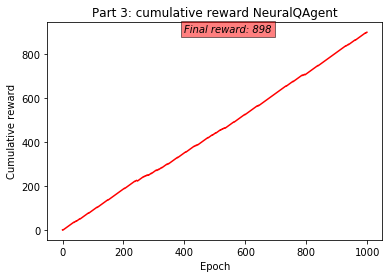

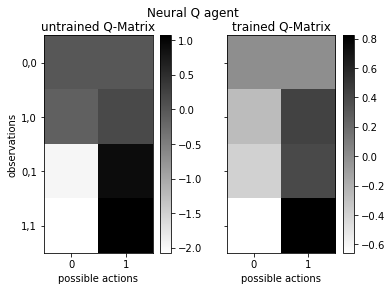

In [32]:
class MyChain(chainer.Chain):
    def __init__(self):
        super(MyChain, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, 4)
            self.l2 = L.Linear(4, 2)

    def __call__(self, x):
        h = self.l1(x)
        return self.l2(h)

class RandomAgent(object):

    def __init__(self, env):
        """
        Args:
        env: an environment
        """
        self.env = env
        self.model = MyChain()
        self.optimizer = optimizers.SGD(lr=10**-4)  # Using Stochastic Gradient Descent
        self.optimizer.setup(self.model)
        self.loss = None

        statespace = [[0, 0], [1, 0], [0, 1], [1, 1]]

        self.model2 = MyChain()
        self.optimizer2 = optimizers.SGD(lr=10 ** -4)  # Using Stochastic Gradient Descent
        self.optimizer2.setup(self.model2)
        self.QI = 0 + self.model2(chainer.Variable(np.atleast_2d(np.asarray(statespace, dtype='float32'))))._data[0]





    def act(self, observation):
        """
        Act based on observation and train agent on cumulated reward (return)
        :param observation: new observation
        :param reward: reward gained from previous action; None indicates no reward because of initial state
        :return: action (Variable)
        """

        # Make two predictions, one for both actions!
        # input_0 = np.atleast_2d(np.append(observation, 0).astype(np.float32))
        # predict_0 = self.model(chainer.Variable(input_0))
        #
        # input_1 = np.atleast_2d(np.append(observation, 1).astype(np.float32))
        # predict_1 = self.model(chainer.Variable(input_1))
        #
        # # Choose prediction with highest Qvalue
        # Qvalues = predict_0.data[0][0], predict_1.data[0][0]

        Qvalues = self.model(chainer.Variable(np.atleast_2d(observation)))
        if np.random.rand() < 0.01:
            choice = int(np.random.rand() < 0.5)
        else:
            choice = np.argmax(Qvalues._data[0])

        #print("Predicted value " + str(Qvalues)) # For debugging
        #print("Choice " + str(choice))
        return choice


    def train(self, a, old_obs, reward, new_obs):
        """
        :param a: action
        :param old_obs: old observation
        :param r: reward
        :param new_obs: new observation
        :return:
        """

        #input = np.atleast_2d(np.append(old_obs, a).astype(np.float32))
        input = np.atleast_2d(old_obs)
        target=np.zeros((2,1))
        self.model.cleargrads()
        target[a] = reward
        target[np.abs(a-1)]  = -reward
        predict = self.model(chainer.Variable(input))
        target = chainer.Variable(np.atleast_2d(target))
        self.loss = F.sum(chainer.Variable(predict.data[0] - target.data) ** 2)
        self.loss.backward()
        self.optimizer.update()

        #pass
CSR=0
while CSR<300: # If neuralQagent stucks in local minima, do again
    R, agent = apply()
    CSR=np.sum(R)


statespace=[[0,0],[1,0],[0,1],[1,1]]

Q_val=agent.model(chainer.Variable(np.atleast_2d(np.asarray(statespace,dtype='float32'))))._data[0]
plot_cum(R, 'Part 3: cumulative reward NeuralQAgent')
plt.figure()
plt.subplot(1,2,2)
plt.imshow(Q_val,cmap='gist_yarg')
plt.colorbar()
plt.title('trained Q-Matrix')
plt.xticks([0,1])
plt.yticks(range(4),['','','',''])
plt.xlabel('possible actions')
plt.subplot(1,2,1)
plt.imshow(agent.QI,cmap='gist_yarg')
plt.colorbar()
plt.title('untrained Q-Matrix')
plt.xticks([0,1])
plt.yticks(range(4),['0,0','1,0','0,1','1,1'])
plt.ylabel('observations')
plt.xlabel('possible actions')
plt.suptitle('Neural Q agent')
plt.show()

### Part 3 answers
different methods of improvements employing past states:
- (1) using a transition matrix
- (2) using an LSTM
- (3) temporal difference learning (Sutton & Barto, 1990)

different methods of modelling continuous rather than discrete actions:
- (1) why would you want this, given a binary state space?
- (2) if the state space would be continous, one could model how close the action and state are mapping (e.g. MSE): after hitting a certain threshold the reward could be given
- (3) the reward could be modeled as a Gaussian. The closer to the state the more reward is given.

### Bonus - *Yippee ki-yay* - Tabular Q- learning using a Markov chain approach

/Users/Tommy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:49: RuntimeWarning: invalid value encountered in divide


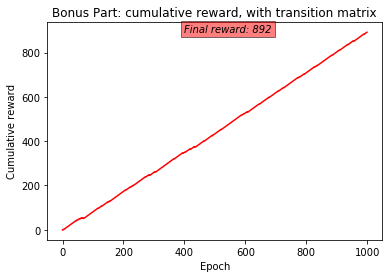

In [38]:
class RandomAgent(object):

    def __init__(self, env):
        """
        Args:
        env: an environment
        """
        self.env = env
        self.Re = np.zeros([4,2]) # 4  Possible states obs (binary), 2 possible actions (0 and 1)
        self.Q = np.zeros([4,4]) # state x state; for prediction of state to next state; we know it's random tho
        self.rawQ = np.zeros([4,4]) # Matrix for visited states and successors
        self.learn_rate = 0.5  # Learning rate for the "Bellman equation"

    def act(self, observation):
        """
        Act based on observation and train agent on cumulated reward (return)
        :param observation: new observation
        :param reward: reward gained from previous action; None indicates no reward because of initial state
        :return: action (Variable)
        """
        #np.random.choice(self.env.n_action)

        state = self.env.asint(observation)
        reward_matrix = self.Re + 0 # 0 so the self.Re matrix doesn't become NaN/Inf because it becomes reward_matrix

        for i in range(1, 16): # Looking 15 steps into the future
            reward_matrix += (self.learn_rate**i) * np.dot(self.Q, reward_matrix) # Basic Markov chain

        choice = np.argmax(reward_matrix[state]) # Given current state, choose highest reward action
        return choice


    def train(self, a, old_obs, r, new_obs):
        """
        :param a: action
        :param old_obs: old observation
        :param r: reward
        :param new_obs: new observation
        :return:
        """
        state = self.env.asint(old_obs)
        self.Re[state][a] += r # Reward per choice

        new_state = self.env.asint(new_obs)
        self.rawQ[state][new_state] += 1 # Visited states and their successor

        Q = self.rawQ + 0
        Qt = np.sum(Q, axis=1)
        self.Q = (Q.T/Qt).T # Make Q a probability transition matrix of going from state to state
        self.Q[np.isnan(self.Q)] = 0

R ,agent= apply()
plot_cum(R, 'Bonus Part: cumulative reward, with transition matrix')
plt.show()